In [5]:
#________________importing libraries_______________
import pandas as pd
import joblib
import shap
import numpy as np
#from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [6]:
#         dataset
df = pd.read_csv(
    "data/processed/dataset.csv",
    low_memory=False
)
print(df.head(5))

           batter        date                                      venue  \
0  A Ashish Reddy  2013-04-07  Rajiv Gandhi International Stadium, Uppal   
1  A Ashish Reddy  2013-04-07  Rajiv Gandhi International Stadium, Uppal   
2  A Ashish Reddy  2013-04-09                      M Chinnaswamy Stadium   
3  A Ashish Reddy  2013-04-17    Maharashtra Cricket Association Stadium   
4  A Ashish Reddy  2013-04-17    Maharashtra Cricket Association Stadium   

          bowler                 bowling_team  rolling_avg_5  venue_avg  \
0  R Vinay Kumar  Royal Challengers Bangalore            2.8   1.971831   
1  R Vinay Kumar  Royal Challengers Bangalore            2.6   1.971831   
2  R Vinay Kumar  Royal Challengers Bangalore            2.4   1.971831   
3       AB Dinda                Pune Warriors            1.2   1.971831   
4     AD Mathews                Pune Warriors            2.6   1.971831   

   pvt_avg  pvp_avg  career_avg  next_match_runs  next_match_wicket  \
0     1.50     1.50  

In [7]:
# baseline for batsman
x = df[['rolling_avg_5','venue_avg','pvt_avg','career_avg']]
y = df['next_match_runs']

In [8]:
# train & test split
split = int(len(df) * 0.8)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
baseline_pred = x_test['rolling_avg_5']
print(baseline_pred)

138274    1.2
138275    1.6
138276    2.4
138277    2.2
138278    2.4
         ... 
172838    0.4
172839    1.6
172840    0.8
172841    0.6
172842    0.6
Name: rolling_avg_5, Length: 34569, dtype: float64


In [10]:
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("Baseline RMSE:",baseline_rmse)
print("Baseline MAE:",baseline_mae)
print("Baseline R2:",baseline_r2)

Baseline RMSE: 2.5942796057924733
Baseline MAE: 1.8595967485319216
Baseline R2: -0.19182513469457096


In [11]:
# linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print("Linear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("MAE :", mean_absolute_error(y_test, lr_pred))
print("R2  :", r2_score(y_test, lr_pred))


Linear Regression
RMSE: 2.3642736097652595
MAE : 1.6529991898317073
R2  : 0.010138469881734946


In [12]:
# Random forest 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)

In [13]:
#    Xgboost
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)

In [14]:
# lightgbm
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)
lgb.fit(x_train,y_train)
lgb_pred = lgb.predict(x_test)
    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 138274, number of used features: 4
[LightGBM] [Info] Start training from score 1.853349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [15]:
  #   evaluation's for models
def evaluate(y_true, y_pred, name):
  print(f"\n{name}")
  print("RMSE:",np.sqrt(mean_squared_error(y_true, y_pred)))
  print("MAE:",mean_absolute_error(y_true, y_pred))
  print("R2:",r2_score(y_true, y_pred))

evaluate(y_test, rf_pred, "Random Forest")
evaluate(y_test, xgb_pred, "XGBoost")
evaluate(y_test, lgb_pred, "LightGBM")


Random Forest
RMSE: 2.3635884408435723
MAE: 1.6532400775092528
R2: 0.010712112525836148

XGBoost
RMSE: 2.362151354284323
MAE: 1.649831581784376
R2: 0.01191474162981676

LightGBM
RMSE: 2.3639389398817956
MAE: 1.6540752610803315
R2: 0.010418685669752015


In [16]:
#         Hyper Parameter Tuning for RFR
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestRegressor

#param_grid = {
 #   'n_estimators': [100,200],
  #  'max_depth': [5,7],
   # 'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2]
#}
#grid = GridSearchCV(
   # estimator=RandomForestRegressor(
    #    random_state=42,
#),
 #   param_grid=param_grid,
  #  cv=2,
   # scoring='neg_root_mean_squared_error',
    #n_jobs=-1
#)

#grid.fit(x_train, y_train)

#print("Best Parameters:", grid.best_params_)
#print("Best RMSE:", -grid.best_score_)

#best_rf = grid.best_estimator_
#best_rf.fit(x_train, y_train)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 2.339336689308972


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples a

In [17]:
# hyper parameter tuning using xgboost
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'max_depth':[3, 5],
    'learning_rate':[0.03,0.05],
    'n_estimators': [200,300]
}

grid = GridSearchCV(
    estimator=XGBRegressor(
        random_state=42,
        objective='reg:squarederror'
    ),
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid.fit(x_train, y_train)

print("Best Parameters:",grid.best_params_)
print("Best RMSE:", -grid.best_score_)

best_xgb = grid.best_estimator_
best_xgb.fit(x_train, y_train)


Best Parameters: {'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300}
Best RMSE: 2.338461818711582


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

100%|===================| 34513/34569 [04:36<00:00]        

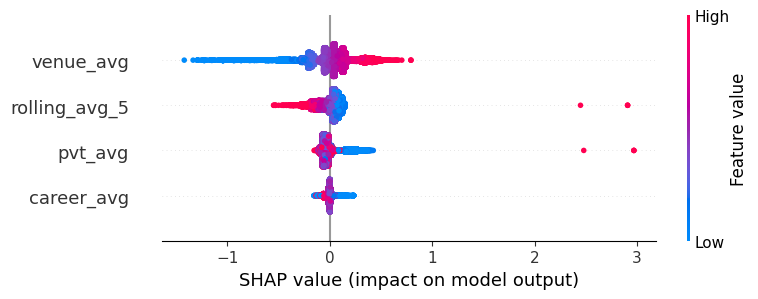

In [18]:
# shap values for model prediction
explainer = shap.Explainer(best_xgb,x_train)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)

100%|===================| 34532/34569 [07:26<00:00]        

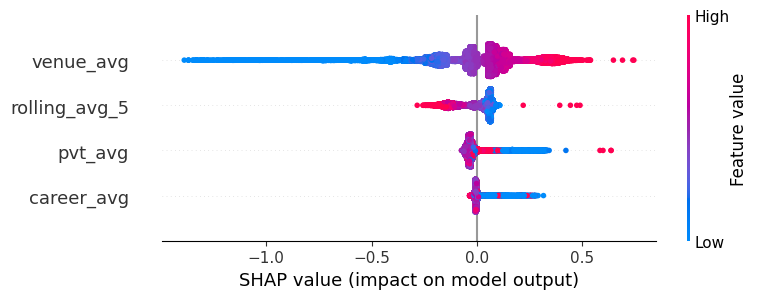

In [31]:
#___________Random Forest SHAP______
#rf_explainer = shap.Explainer(best_rf,x_train)
#rf_shap_values= rf_explainer(x_test)
#shap.summary_plot(rf_shap_values, x_test)


In [19]:
# baseline for bowler
X_bowler = df[['rolling_avg_wickets','venue_avg_wickets','opponent_wickets',
             'bowler_economy',
        'bowler_career_wickets_avg'
            ]]
y_bowler = df['next_match_wicket']

In [20]:
# Time-based split
split = int(len(df) * 0.8)

#Xb_train, Xb_test = X_bowler[:split], X_bowler[split:]
#yb_train, yb_test = y_bowler[:split], y_bowler[split:]
Xb_train = X_bowler.iloc[:split]
Xb_test  = X_bowler.iloc[split:]

yb_train = y_bowler.iloc[:split]
yb_test  = y_bowler.iloc[split:]

In [21]:
baseline_bowler_pred = Xb_test['rolling_avg_wickets']
print(baseline_bowler_pred.head())

138274    0.0
138275    0.0
138276    0.0
138277    0.2
138278    0.0
Name: rolling_avg_wickets, dtype: float64


In [22]:
baseline_bowler_rmse = np.sqrt(mean_squared_error(yb_test, baseline_bowler_pred))
baseline_bowler_mae  = mean_absolute_error(yb_test, baseline_bowler_pred)
baseline_bowler_r2   = r2_score(yb_test, baseline_bowler_pred)

print("Bowler Baseline RMSE:", baseline_bowler_rmse)
print("Bowler Baseline MAE :", baseline_bowler_mae)
print("Bowler Baseline R2  :", baseline_bowler_r2)


Bowler Baseline RMSE: 0.2776339701224685
Bowler Baseline MAE : 0.12878012091758512
Bowler Baseline R2  : -0.20628683633312095


In [24]:
# Random forest 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    n_jobs=1,
)
rf.fit(Xb_train, yb_train)
rf_pred = rf.predict(Xb_test)

In [25]:
xgb = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(Xb_train, yb_train)
xgb_pred = xgb.predict(Xb_test)

In [26]:
# lightgbm
lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5
)
lgb.fit(Xb_train,yb_train)
lgb_pred = lgb.predict(Xb_test)
    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 138274, number of used features: 5
[LightGBM] [Info] Start training from score 0.071322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [27]:
  #   evaluation's for models
def evaluate(yb_true, yb_pred, name):
  print(f"\n{name}")
  print("RMSE:",np.sqrt(mean_squared_error(yb_true, yb_pred)))
  print("MAE:",mean_absolute_error(yb_true, yb_pred))
  print("R2:",r2_score(yb_true, yb_pred))

evaluate(yb_test, rf_pred, "Random Forest")
evaluate(yb_test, xgb_pred, "XGBoost")
evaluate(yb_test, lgb_pred, "LightGBM")


Random Forest
RMSE: 0.2512706183045118
MAE: 0.1280656359912512
R2: 0.011927531155273341

XGBoost
RMSE: 0.2511429398544581
MAE: 0.12801548879928057
R2: 0.012931417008884782

LightGBM
RMSE: 0.25152099828572644
MAE: 0.12837512428918027
R2: 0.009957409648875593


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [5, 7],      
    'min_samples_split': [2, 5],   
    'min_samples_leaf': [1, 2],     
    'max_features': ['sqrt', 'log2'] 
}

rf_base = RandomForestRegressor(
    random_state=42,
    n_jobs=1  
)
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=2,                          
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                      
)
rf_grid.fit(Xb_train, yb_train)

print("Best Parameters:", rf_grid.best_params_)
print("Best RMSE", -rf_grid.best_score_)

# ---------------- Train final tuned model ----------------
best_rf_bowler = rf_grid.best_estimator_
best_rf_bowler.fit(Xb_train, yb_train)


Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE 0.256258494217843


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",5
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

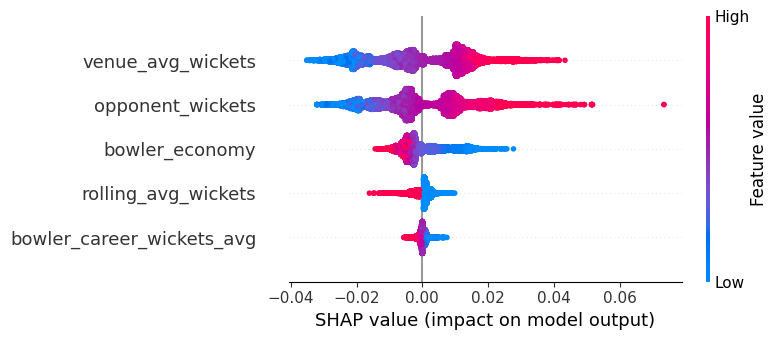

In [35]:
# ----- BOWLER: Random Forest SHAP  -----
rf_explainer = shap.TreeExplainer(best_rf_bowler) 
rf_shap = rf_explainer(Xb_test)
shap.summary_plot(rf_shap, Xb_test)
